In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.table import Table
import matplotlib as mpl
import pandas as pd

In [2]:
 query = """
 SELECT g.source_id, g.ra, g.dec, parallax, parallax_error,
        pmra, pmra_error, pmdec, bp_rp,
        phot_g_mean_mag, phot_g_mean_flux_over_error,
        phot_bp_mean_mag, phot_bp_mean_flux_over_error,
        phot_rp_mean_mag, phot_rp_mean_flux_over_error,
        phot_g_mean_mag + 5.0*log10(parallax/100.0) AS M_G, bp_rp,
        s.ra,s.dec, u_mag, u_mag_error, g_mag, g_mag_error, r_mag, r_mag_error, i_mag, i_mag_error, z_mag, z_mag_error, clean_flag,
        pan.ra,pan.dec,g_mean_psf_mag,g_mean_psf_mag_error,r_mean_psf_mag,r_mean_psf_mag_error,i_mean_psf_mag,i_mean_psf_mag_error,z_mean_psf_mag,z_mean_psf_mag_error,y_mean_psf_mag,y_mean_psf_mag_error,s.sdssdr9_oid

 FROM   gaiadr3.gaia_source AS g, gaiadr1.sdssdr9_original_valid AS s, gaiadr2.sdssdr9_best_neighbour AS xs,
        gaiadr2.panstarrs1_original_valid AS pan, gaiadr3.panstarrs1_best_neighbour AS xpan
 WHERE g.source_id = xs.source_id AND s.sdssdr9_oid = xs.sdssdr9_oid
   AND g.source_id = xpan.source_id AND pan.obj_id = xpan.original_ext_source_id
   AND parallax > 10.0 AND parallax_over_error > 10.0
   AND phot_bp_mean_flux_over_error > 10.0
   AND phot_rp_mean_flux_over_error > 10.0
   AND phot_g_mean_mag + 5.0*log10(parallax/100.0) > (3.333333*(phot_bp_mean_mag - phot_rp_mean_mag) + 8.333333)
   AND (astrometric_sigma5d_max < 1.5 OR (ruwe <= 1.1 AND ipd_gof_harmonic_amplitude < 1))
   AND ((phot_bp_n_obs >2 AND phot_rp_n_obs >2) OR phot_g_mean_mag < 19)
   AND ((astrometric_excess_noise_sig < 2 OR (astrometric_excess_noise_sig >= 2 AND astrometric_excess_noise < 1.5)) OR astrometric_params_solved < 32)
 """

In [42]:
 query_data = Gaia.launch_job_async(query)
 query_result = query_data.get_results()
 gaia_data = query_result.to_pandas()
 #print(gaia_data)
 sdssids = gaia_data['sdssdr9_oid']
 objidstr = ",".join(str(obj_id) for obj_id in sdssids)
 #print(objidstr)

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
 gaia_data.to_csv('gaia_query.csv')


In [5]:
gaia_data = pd.read_csv('gaia_query.csv')
TEST_DATA_Raw = pd.read_csv('TEST_DATA-export (1).csv')

In [6]:
montreal_df = pd.read_csv('MWDD-export.csv')
DA_raw = pd.read_csv('DA-export (1).csv')
DB_raw = pd.read_csv('DB-export (1).csv')
DC_raw = pd.read_csv('DC-export (1).csv')
DQ_raw = pd.read_csv('DQ-export (1).csv')
DZ_raw = pd.read_csv('DZ-export (1).csv')
DA_raw.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10171 entries, 0 to 10170
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wdid      10171 non-null  object 
 1   teff      10147 non-null  float64
 2   logL      544 non-null    float64
 3   parallax  10171 non-null  float64
 4   Dpc       10171 non-null  float64
 5   G         10171 non-null  float64
 6   BP        10170 non-null  float64
 7   RP        10170 non-null  float64
dtypes: float64(7), object(1)
memory usage: 635.8+ KB


In [7]:
# If we used this data for a machine learning model, we would loose a significant amount of our data due to much of the lumenocity being NA
# To see the exact numbers run [DA--DZ]_raw.dropna() and print them.

In [8]:
DA_fix = DA_raw.drop('logL', axis = 1)
DB_fix = DB_raw.drop('logL', axis = 1)
DC_fix = DC_raw.drop('logL', axis = 1)
DQ_fix = DQ_raw.drop('logL', axis = 1)
DZ_fix = DZ_raw.drop('logL', axis = 1)
TEST_DATA_fix = TEST_DATA_Raw.drop('logL', axis = 1)

In [9]:
DA_Log_fix= DA_fix.where((DA_fix.parallax > 0))
DB_Log_fix= DB_fix.where((DB_fix.parallax > 0))
DC_Log_fix= DC_fix.where((DC_fix.parallax > 0))
DQ_Log_fix= DQ_fix.where((DQ_fix.parallax > 0))
DZ_Log_fix= DZ_fix.where((DZ_fix.parallax > 0))
TEST_DATA_Log_fix =  TEST_DATA_fix.where((TEST_DATA_Raw.parallax > 0))

DA_fix = DA_Log_fix.dropna()
DB_fix = DB_Log_fix.dropna()
DC_fix = DC_Log_fix.dropna()
DQ_fix = DQ_Log_fix.dropna()
DZ_fix = DZ_Log_fix.dropna()
TEST_DATA_fix = TEST_DATA_Log_fix.dropna()

#DA_Log_fix= DA_fix.where((DA_fix.parallax > 0) & (DA_fix.parallax <= 500))

In [10]:
#print(DA_Log_fix.to_string())

<Figure size 640x480 with 0 Axes>

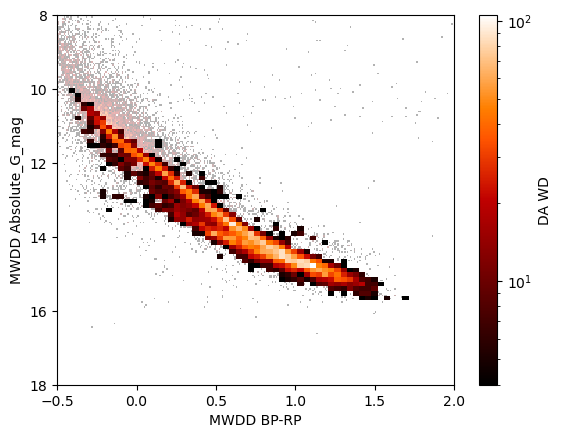

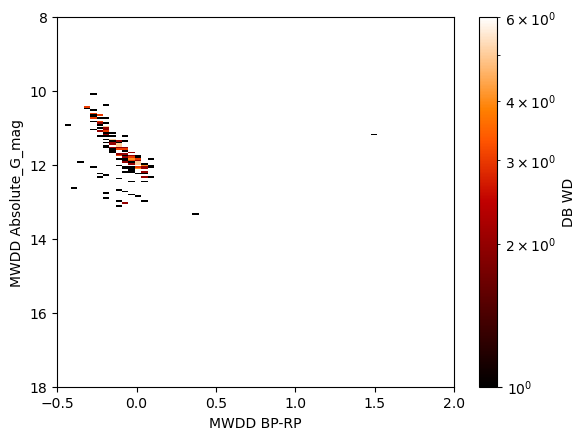

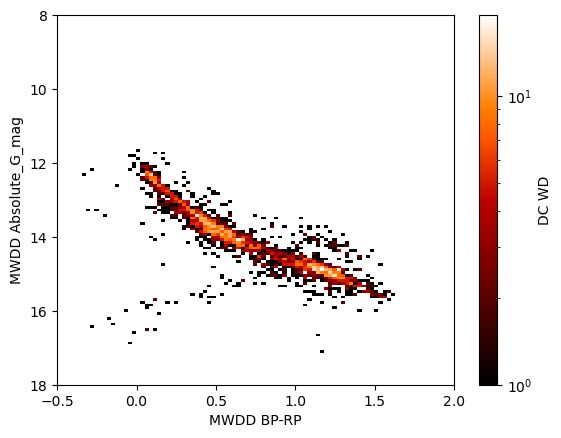

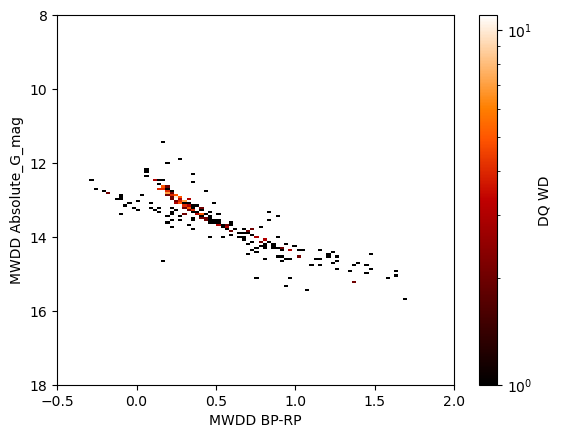

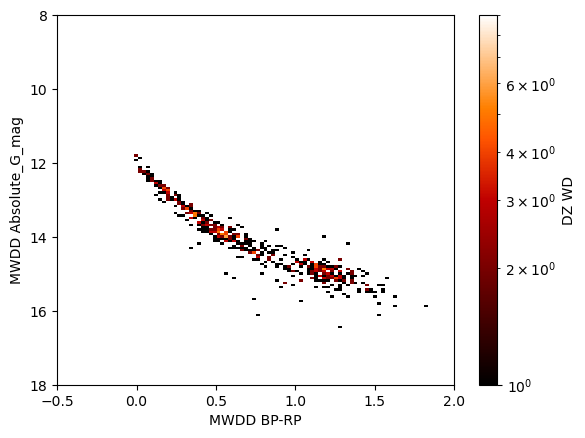

<Figure size 640x480 with 0 Axes>

In [30]:
plt.hist2d(DA_fix.BP-DA_fix.RP, DA_fix.G + 5.0-5.*np.log10(1000/DA_fix.parallax), bins=75, cmin = 4, norm=mpl.colors.LogNorm(), cmap = 'gist_heat', label = 'DA WD' )
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar(label = 'DA WD')
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.figure()

plt.hist2d(DB_fix.BP-DB_fix.RP, DB_fix.G + 5.0-5.*np.log10(1000/DB_fix.parallax), bins=75, cmin = -5, norm=mpl.colors.LogNorm(), cmap = 'gist_heat', label = 'DB WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar(label = 'DB WD')
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.figure()

plt.hist2d(DC_fix.BP-DC_fix.RP, DC_fix.G + 5.0-5.*np.log10(1000/DC_fix.parallax), bins=75, norm=mpl.colors.LogNorm(), cmap = 'gist_heat', label = 'DC WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar(label = 'DC WD')
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.figure()

#plt.scatter(DQ_fix.BP-DQ_fix.RP, DQ_fix.G + 5.0-5.*np.log10(1000/DQ_fix.parallax), alpha = 0.3)
plt.hist2d(DQ_fix.BP-DQ_fix.RP, DQ_fix.G + 5.0-5.*np.log10(1000/DQ_fix.parallax), bins=75, norm=mpl.colors.LogNorm(), cmap = 'gist_heat', label = 'DQ WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar(label = 'DQ WD')
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.figure()

#plt.scatter(DZ_fix.BP-DZ_fix.RP, DZ_fix.G + 5.0-5.*np.log10(1000/DZ_fix.parallax), alpha = 0.3)
plt.hist2d(DZ_fix.BP-DZ_fix.RP, DZ_fix.G + 5.0-5.*np.log10(1000/DZ_fix.parallax), bins=75, norm=mpl.colors.LogNorm(), cmap = 'gist_heat')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar(label = 'DZ WD')
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.figure()

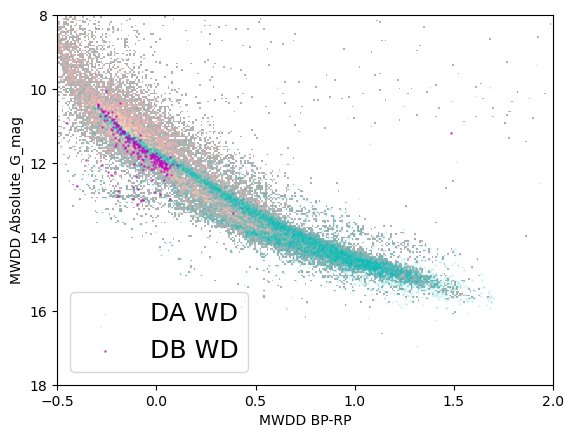

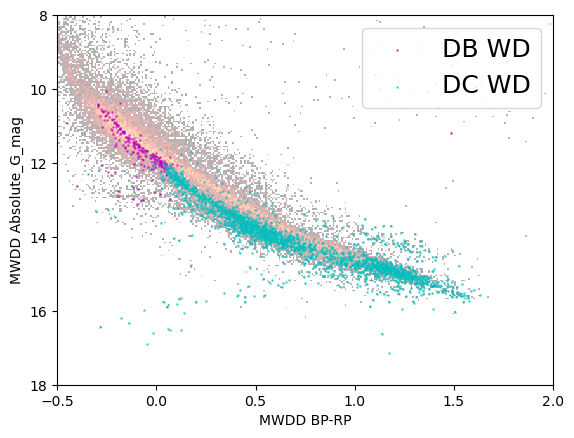

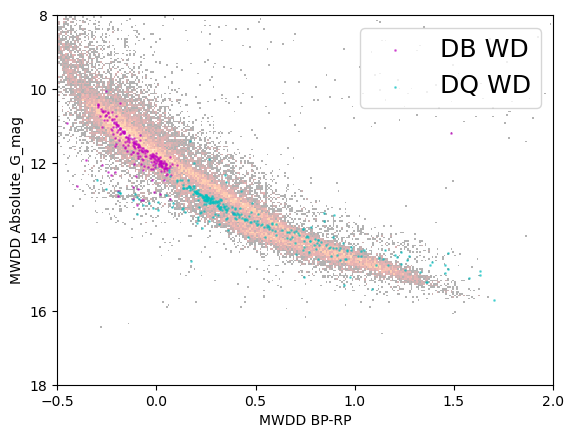

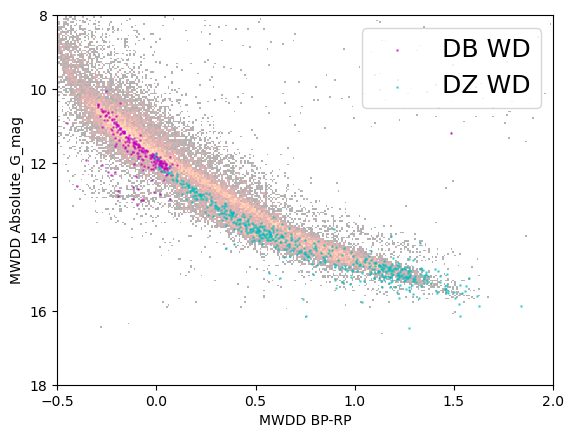

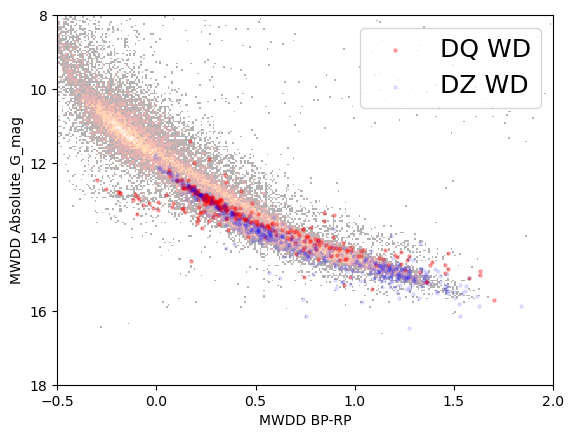

In [41]:

plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat',alpha = 0.3)

plt.scatter(DA_fix.BP-DA_fix.RP, DA_fix.G + 5.0-5.*np.log10(1000/DA_fix.parallax), s = 1, alpha = 0.1, c = 'c', label= 'DA WD')
plt.scatter(DB_fix.BP-DB_fix.RP, DB_fix.G + 5.0-5.*np.log10(1000/DB_fix.parallax), s=1, alpha = 0.5, c = 'm', label= 'DB WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.legend(fontsize=18)
plt.figure()

plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat',alpha = 0.3)
plt.scatter(DB_fix.BP-DB_fix.RP, DB_fix.G + 5.0-5.*np.log10(1000/DB_fix.parallax), s = 1, alpha = 0.5, c = 'm', label= 'DB WD')
plt.scatter(DC_fix.BP-DC_fix.RP, DC_fix.G + 5.0-5.*np.log10(1000/DC_fix.parallax), s = 1, alpha = 0.5, c = 'c', label= 'DC WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.legend(fontsize=18)
plt.figure()

plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat',alpha = 0.3)
plt.scatter(DB_fix.BP-DB_fix.RP, DB_fix.G + 5.0-5.*np.log10(1000/DB_fix.parallax), s = 1, alpha = 0.5, c = 'm', label= 'DB WD')
plt.scatter(DQ_fix.BP-DQ_fix.RP, DQ_fix.G + 5.0-5.*np.log10(1000/DQ_fix.parallax), s = 1, alpha = 0.5, c = 'c', label= 'DQ WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.legend(fontsize=18)
plt.figure()

plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat',alpha = 0.3)
plt.scatter(DB_fix.BP-DB_fix.RP, DB_fix.G + 5.0-5.*np.log10(1000/DB_fix.parallax), s = 1, alpha = 0.5, c = 'm', label= 'DB WD')
plt.scatter(DZ_fix.BP-DZ_fix.RP, DZ_fix.G + 5.0-5.*np.log10(1000/DZ_fix.parallax), s = 1, alpha = 0.5, c = 'c', label= 'DZ WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.legend(fontsize=18)
plt.figure()

plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat',alpha = 0.3)
plt.scatter(DQ_fix.BP-DQ_fix.RP, DQ_fix.G + 5.0-5.*np.log10(1000/DQ_fix.parallax), s = 5, alpha = 0.3, c='r',label= 'DQ WD')
plt.scatter(DZ_fix.BP-DZ_fix.RP, DZ_fix.G + 5.0-5.*np.log10(1000/DZ_fix.parallax), s = 5, alpha = 0.1, c='b', label= 'DZ WD')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')
plt.legend(fontsize=18)

In [13]:
gaia_ra_numpy = gaia_data['ra'].to_numpy()
gaia_dec_numpy = gaia_data['dec'].to_numpy()

Text(0, 0.5, 'MWDD Absolute_G_mag')

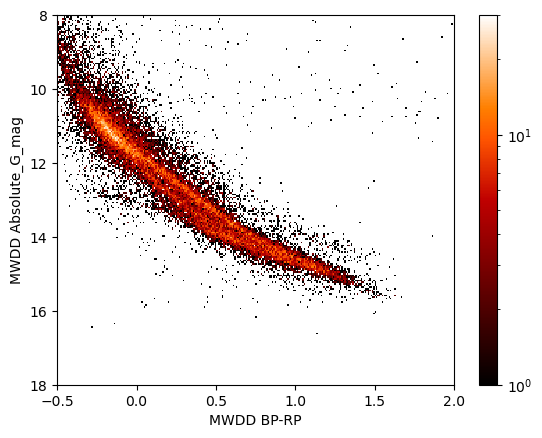

In [28]:
plt.hist2d(TEST_DATA_fix.BP-TEST_DATA_fix.RP, TEST_DATA_fix.G + 5.0-5.*np.log10(1000/TEST_DATA_fix.parallax), bins=400, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar()
plt.xlabel('MWDD BP-RP')
plt.ylabel('MWDD Absolute_G_mag')

(20.0, 10.0)

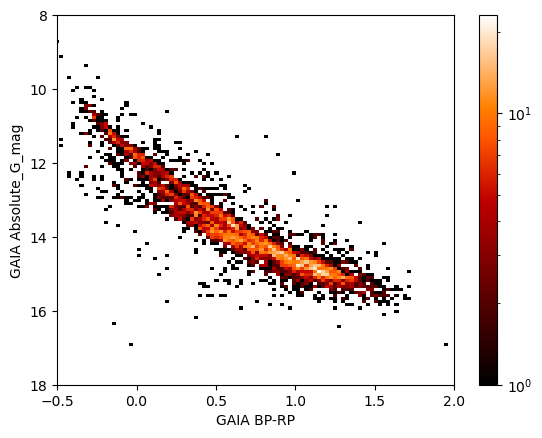

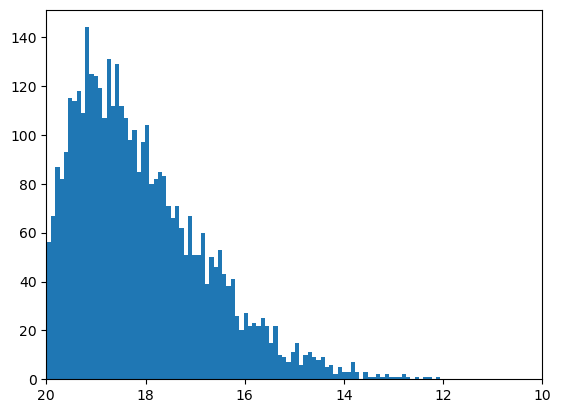

In [33]:
plt.hist2d(gaia_data.bp_rp, gaia_data.M_G, bins=100, cmin = 0, norm=mpl.colors.LogNorm(), cmap = 'gist_heat')
plt.xlabel('GAIA BP-RP')
plt.ylabel('GAIA Absolute_G_mag')
plt.ylim(18,8)
plt.xlim(-0.5,2)
plt.colorbar()
plt.figure()
plt.hist(gaia_data.phot_g_mean_mag, bins = 100)
plt.xlim(20,10)


In [16]:
montreal_ra_numpy = montreal_df['icrsra'].to_numpy()
montreal_dec_numpy = montreal_df['icrsdec'].to_numpy()

In [17]:
coords = SkyCoord(ra=montreal_ra_numpy,dec=montreal_dec_numpy, unit=(u.hourangle,u.deg))

In [18]:
coords = SkyCoord(ra=montreal_df['icrsra'].to_numpy(),
dec=montreal_df['icrsdec'].to_numpy(), unit=(u.hourangle,u.deg))

In [19]:
gaia_coords=SkyCoord(ra=gaia_data['ra'].to_numpy()*u.deg,dec=gaia_data['dec'].to_numpy()*u.deg)

In [20]:
montreal_df['ra_deg'] = coords.ra.deg
montreal_df['dec_deg']= coords.dec.deg

In [21]:
idx, sep2d,_ = coords.match_to_catalog_sky(gaia_coords)

In [22]:
max_separation = 1.0*u.arcsec
matches_within_radius = sep2d < max_separation

In [23]:
matched_gaia = gaia_data.iloc[idx[matches_within_radius]].reset_index(drop=True)
matched_montreal = montreal_df[matches_within_radius].reset_index(drop=True)